In [1]:
'''Testing the Chopin repo for debugging'''

import warnings; warnings.simplefilter('ignore')  # hide warnings

from matplotlib import pyplot as plt
import numpy as np

from particles import distributions as dists

prior_dict = {'mu': dists.Normal(scale=2.),
              'rho': dists.Uniform(a=-1., b=1.),
              'sigma':dists.Gamma()}
my_prior = dists.StructDist(prior_dict)

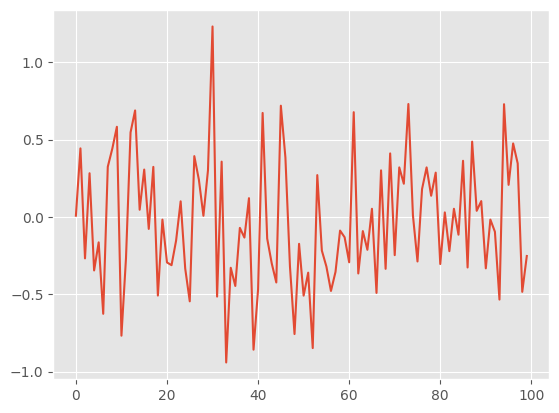

In [2]:
from particles import state_space_models as ssm

class StochVol(ssm.StateSpaceModel):
    default_parameters = {'mu':-1., 'rho':0.95, 'sigma': 0.2}
    def PX0(self):  # Distribution of X_0
        return dists.Normal(loc=self.mu, scale=self.sigma / np.sqrt(1. - self.rho**2))
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(loc=self.mu + self.rho * (xp - self.mu), scale=self.sigma)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=0., scale=np.exp(x))
    

my_model = StochVol(mu=-1., rho=.9, sigma=.1)  # actual model
true_states, data = my_model.simulate(100)  # we simulate from the model 100 data points

plt.style.use('ggplot')
plt.figure()
plt.plot(data)

In [3]:
from particles import mcmc
from particles import datasets as dts  # real datasets available in the package

# real data
T = 50
data = dts.GBP_vs_USD_9798().data[:T]

my_pmmh = mcmc.PMMH(ssm_cls=StochVol, prior=my_prior, data=data, Nx=1000,
                    niter=10000)

my_pmmh.run();  # may take several seconds...

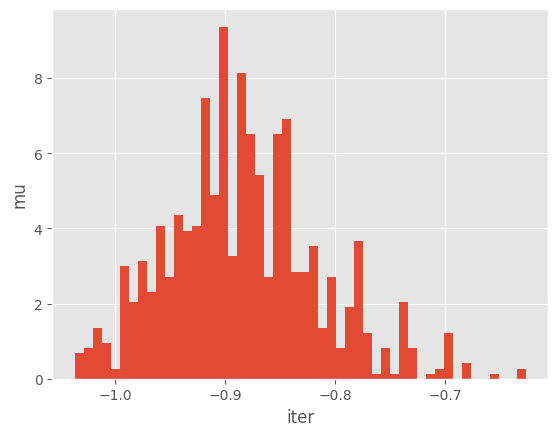

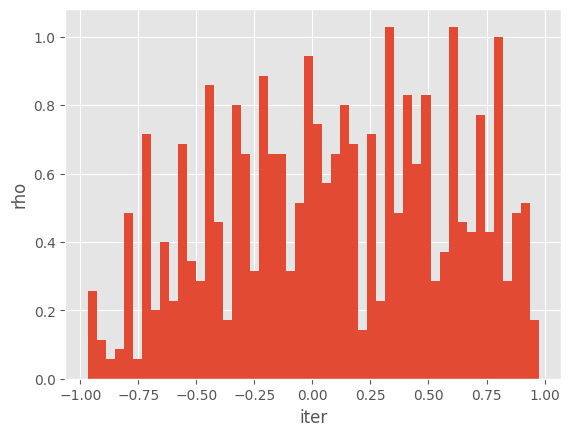

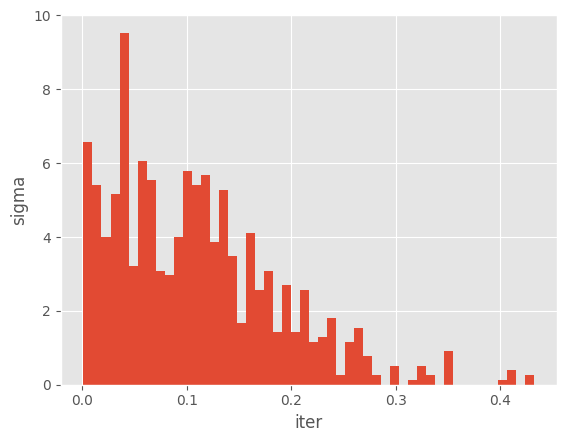

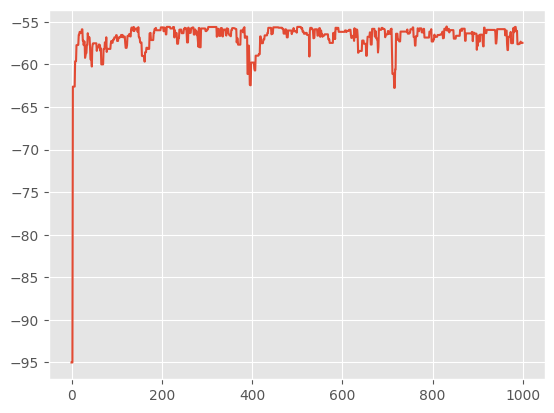

In [5]:
burn_in = 100

for p in prior_dict.keys():  # loop over mu, theta, rho
    plt.figure()
    plt.hist(my_pmmh.chain.theta[p][burn_in:],density=True,bins = 50)
    plt.xlabel('iter')
    plt.ylabel(p)
    plt.show()

plt.plot(my_pmmh.chain.lpost)